In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
#设置显示中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["axes.unicode_minus"] = False

#图像清晰度调整
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.conv_1x1_output(x)
        return x

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1, pretrained_backbone=True, backbone_weights_path=None):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = models.resnet50(pretrained=False)
        if pretrained_backbone and backbone_weights_path:
            state_dict = torch.load(backbone_weights_path)
            self.backbone.load_state_dict(state_dict, strict=False)
        
        # Encoder layers: use layers up to layer4 of ResNet
        self.encoder = nn.Sequential(*list(self.backbone.children())[:-2])

        # ASPP with fixed output
        self.aspp = ASPP(in_channels=2048, out_channels=256)

        # 1x1 Convolution to reduce encoder output channels to 256
        self.encoder_reduction = nn.Conv2d(2048, 256, kernel_size=1)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Encoder
        encoder_output = self.encoder(x)  # Expected shape: [batch, 2048, h/16, w/16]
        
        # ASPP
        aspp_output = self.aspp(encoder_output)  # Shape: [batch, 256, h/16, w/16]
        
        # Reduce encoder output channels to 256
        encoder_upsampled = self.encoder_reduction(encoder_output)  # Shape: [batch, 256, h/16, w/16]
        
        # Concatenate ASPP output with reduced encoder output
        decoder_input = torch.cat([aspp_output, encoder_upsampled], dim=1)  # Shape: [batch, 512, h/16, w/16]
        
        # Decode
        decoder_output = self.decoder(decoder_input)  # Output shape: [batch, num_classes, h/16, w/16]
        
        # Upsample to match input size
        x = F.interpolate(decoder_output, size=(256, 256), mode='bilinear', align_corners=False)
        return x

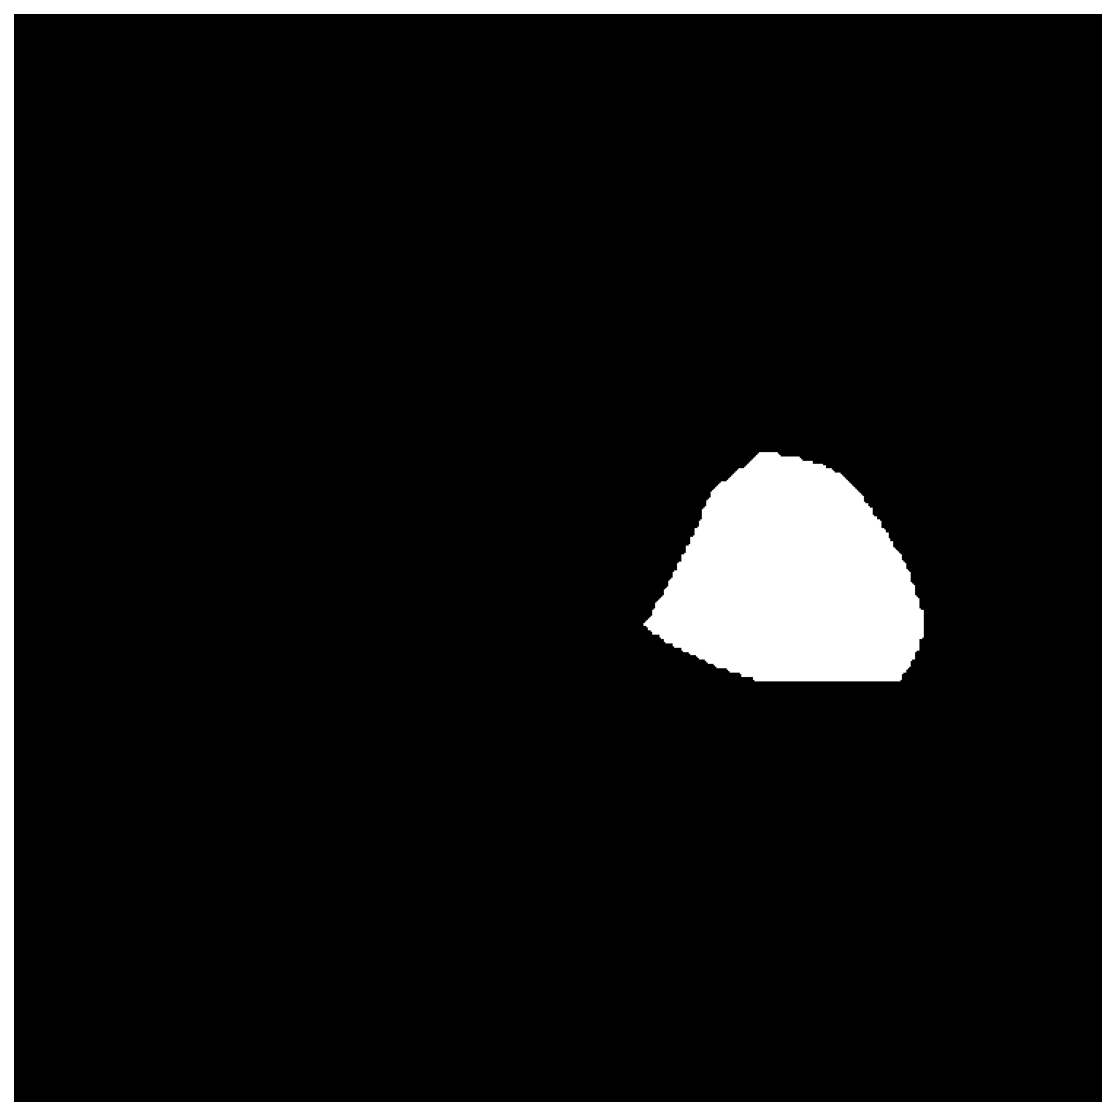

In [10]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = DeepLabV3Plus().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测的掩码部分标红并叠加到原图上（半透明红色）
def apply_mask_on_image(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建红色的遮罩层
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255 (RGB)

    # 叠加红色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * red_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 可视化测试结果并保存黑白掩码图像
def visualize_results(original_image_path, image_with_mask, predicted_mask):
    # 只显示黑白二值化掩码
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示二值化掩码
    plt.figure(figsize=(10, 10))

    # 黑白二值化掩码
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    # 保存图像到桌面
    output_path = '/Users/camus/Desktop/predicted_binary_mask.png'  # 保存路径
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # 显示图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'DeepLabV3+_model.pth'  # 你训练好的模型路径
# test_image_path = '/Users/camus/Desktop/虫害/part1.jpg'  # 你的测试图像路径
# test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径

# test_image_path = '/Users/camus/Desktop/trainX/image/image-216.png'  # 你的测试图像路径
test_image_path = '/Users/camus/Desktop/4.png'  # 你的测试图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标红
image_with_mask = apply_mask_on_image(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_mask, predicted_mask)

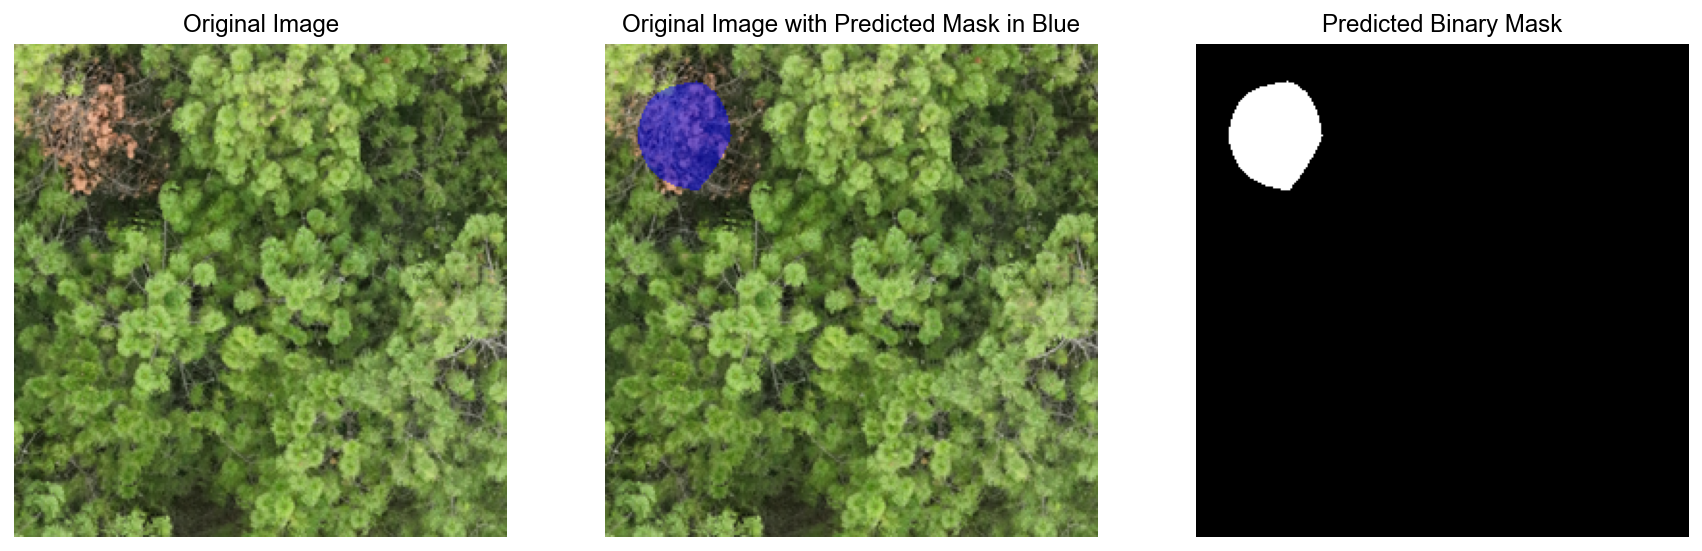

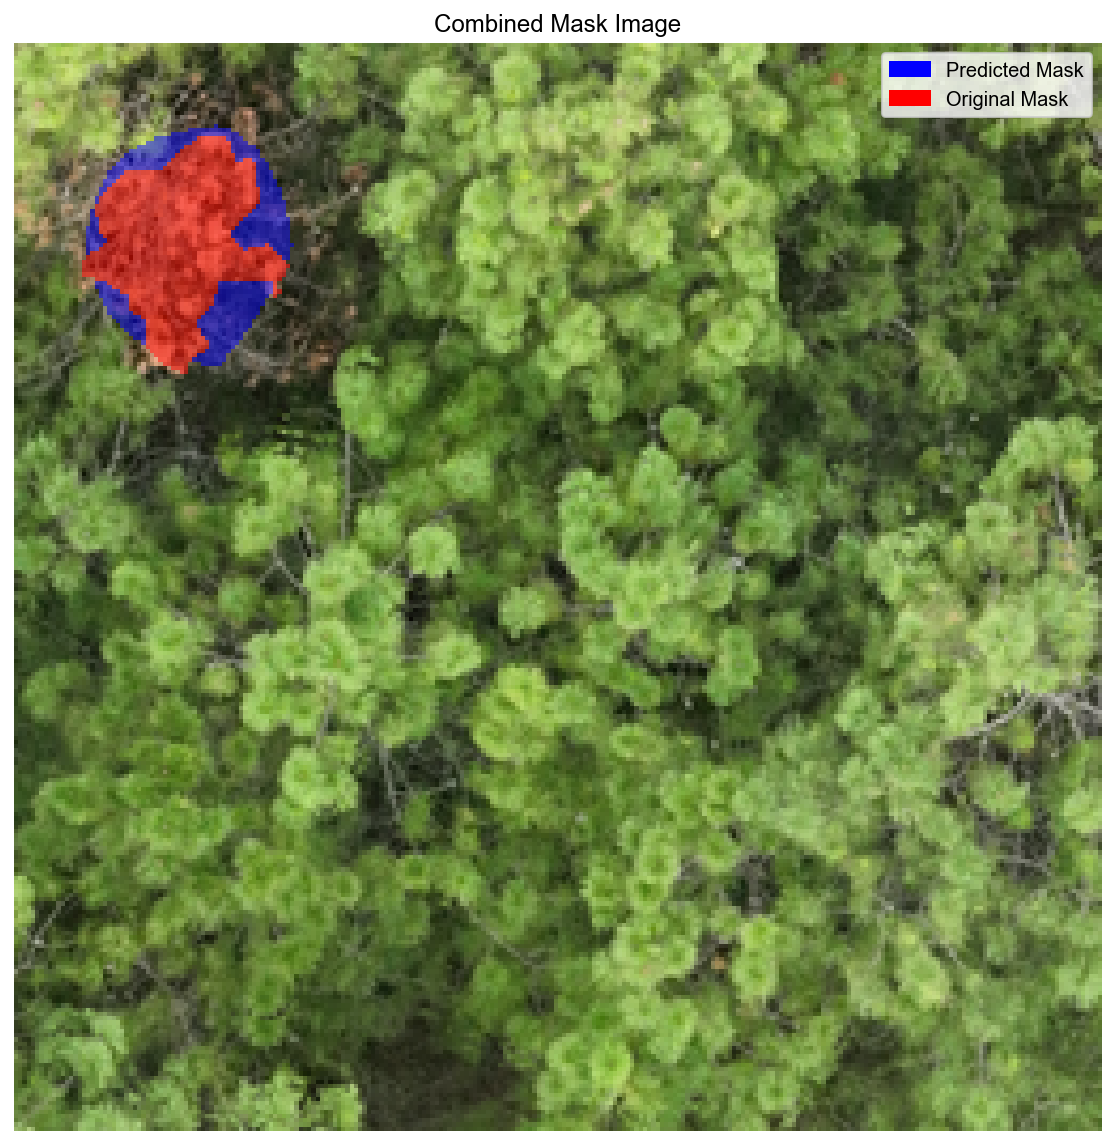

In [4]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.patches as mpatches

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = DeepLabV3Plus().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测掩码部分标蓝并叠加到原图上（蓝色掩码）
def apply_mask_on_image_with_blue(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建蓝色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255 (RGB)

    # 叠加蓝色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 将预测掩码和原始掩码叠加在原图上，分别以蓝色和红色透明显示
def apply_mask_on_image_with_alpha(image_path, predicted_mask, original_mask_path, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码和原始掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(image_np.shape[:2][::-1])) / 255  # 归一化

    # 创建蓝色和红色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255

    # 叠加蓝色（预测掩码）和红色（原始掩码）的透明遮罩
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]
    image_with_mask[original_mask == 1] = (1 - alpha) * image_np[original_mask == 1] + alpha * red_mask[original_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 单独显示蓝红叠加图并添加图例注释
def show_combined_mask_image_with_legend(image_with_mask):
    plt.figure(figsize=(10, 10))  # 调整图像大小
    plt.imshow(image_with_mask)
    plt.title("Combined Mask Image")
    plt.axis('off')

    # 创建图例注释
    blue_patch = mpatches.Patch(color='blue', label='Predicted Mask')
    red_patch = mpatches.Patch(color='red', label='Original Mask')
    plt.legend(handles=[blue_patch, red_patch], loc='upper right')  # 图例位置在右上角

    plt.show()

# 可视化测试结果
def visualize_results(original_image_path, image_with_blue_mask, predicted_mask):
    original_image = Image.open(original_image_path)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示三张图片
    plt.figure(figsize=(15, 5))

    # 原图
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # 蓝色掩码叠加图
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_blue_mask)
    plt.title("Original Image with Predicted Mask in Blue")
    plt.axis('off')

    # 黑白二值化掩码
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis('off')

    # 显示所有图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'DeepLabV3+_model.pth'  # 你训练好的模型路径
test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径
original_mask_path = '/Users/camus/Desktop/image-124_binary.png'  # 原始掩码图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标蓝
image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_blue_mask, predicted_mask)

# 生成叠加有透明蓝红掩码的图像
image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)

# 显示结果并添加注释
show_combined_mask_image_with_legend(image_with_mask)